* https://github.com/jikexueyuanwiki/tensorflow-zh/blob/master/SOURCE/tutorials/word2vec/index.md

# Vector Representation of Words

word embedding (词向量)
* sparse
* 分布式假设: 上下文情景中的词汇有类似语义
    * 潜在语义分析 latent semantic analysis
    * neural net language model
* word2vec
    * 连续词袋模型 CBOW
        * 根据源词上下文词汇预测目标词汇
        * 分布式信息进行了平滑处理(?)
    * skip-gram 模型
        * 通过目标词汇预测源词汇 (下文重点讲解)

当提供前一个单词 h (history) 后一个单词的概率 $w_t$ (target) 
$$P(w_t|h) = softmax(score(w_t,h))$$
$score(w_t,h)$ 计算文字 $w_t$ 和上文 h 的相容性, 通常使用向量积

In [1]:
import tensorflow as tf
import numpy as np

In [2]:
import math

vocabulary_size = 1000
embedding_size = 2

# 定义一个嵌套参数矩阵
embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
# 对噪声-比对的损失计算就使用一个逻辑回归模型。
# 对此，我们需要对语料库中的每个单词定义一个权重值和偏差值。(也可称之为输出权重 与之对应的 输入嵌套值)。
nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                                              stddev=1.0 / math.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

# noise-contrastive estimation (NCE)

In [3]:
batch_size = 10
# 建立占位符
train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
train_labels = tf.placeholder(tf.int32, shape=[batch_size,1])

In [4]:
# 对批数据中的单词建立嵌套向量
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

In [5]:
# 使用噪声-比对的训练方式来预测目标单词。

num_sampled = 100
# 计算 NCE 损失函数, 每次使用负标签的样本.
loss = tf.reduce_mean(tf.nn.nce_loss(nce_weights, nce_biases, embed, train_labels,
                 num_sampled, vocabulary_size))

In [6]:
# 计算相应梯度和更新参数的节点
# 使用 SGD 控制器.
optimizer = tf.train.GradientDescentOptimizer(learning_rate=1.0).minimize(loss)

### 训练模型

In [ ]:
# 在循环中使用feed_dict不断给占位符填充数据，同时调用 session.run即可
for inputs, labels in generate_batch(...):
    feed_dict = {training_inputs: inputs, training_labels: labels}
    _, cur_loss = session.run([optimizer, loss], feed_dict=feed_dict)

* 评估 embedding : 类比推理
    * 类似 `king is to queen as father is to ?`
    * `build_eval_graph()` & `eval()`
* 优化
    * 替换 loss function, 如`tf.nn.sampled_softmax_loss()`
    * 如输入数据出现瓶颈, 实现一个数据阅读器
    * 添加新操作优化等

[word2vec 源码](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/word2vec/word2vec_basic.py)

In [7]:
from __future__ import absolute_import
from __future__ import print_function

import collections
import math
import os
import random
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf

In [ ]:
# 下载数据, 因为网络问题下载很慢 直接手动下载了
# Step 1: Download the data. 
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
    """
    Download a file if not present, and make sure it's the right size.
    """
    if not os.path.exists(filename): # 如果当前路径不存在 file
        filename, _ = urllib.request.urlretrieve(url + filename, filename) # 从 url 下载
        statinfo = os.stat(filename) # stat info
    if statinfo.st_size == expected_bytes: # size 大小正确
        print('Found and verified', filename)
    else:
        print(statinfo.st_size) # 不正确 raise exception
        raise Exception('Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

filename = maybe_download('text8.zip', 31344016)

In [8]:
filename = 'text8.zip'
# 解压 text8.zip 读取数据
# Read the data into a list of strings.
def read_data(filename):
    """
    Extract the first file enclosed in a zip file as a list of words
    """
    with zipfile.ZipFile(filename) as f: # reading & writing zipfile
        data = f.read(f.namelist()[0]).split()
    return data

words = read_data(filename)
print('Data size', len(words))

Data size 17005207


In [9]:
# 建立字典, 将少见词 替换为 UNK (unknown)
# Step 2: Build the dictionary and replace rare words with UNK token.

vocabulary_size = 50000 # 词典 size

def build_dataset(words):
    count = [['UNK', -1]]
    # list.extend 延长 list, 不是 append, append 只能加一个元素
    # collections.Counter() 数有多少个 obj, 保存为 dict 形式, unordered
    # most_comment(n)返回 n 个count 数最多的
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1)) # -1 why?
    
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary) # 储存单词, 并编号
    
    data = list()
    unk_count = 0 # 不常见词
    
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else: # 不常见词
            index = 0  # dictionary['UNK']
            unk_count += 1
        data.append(index)
    
    count[0][1] = unk_count
    # 单词和编号倒转
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
del words  # Hint to reduce memory.
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])


Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]


In [10]:
# 生成batch训练集
# Step 3: Function to generate a training batch for the skip-gram model.
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
    global data_index # 前面定义的 =0
    assert batch_size % num_skips == 0 # test condition
    assert num_skips <= 2 * skip_window # ?
    
    batch = np.ndarray(shape=(batch_size), dtype=np.int32) # 按 batch size生成array
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32) #label? 什么 label
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    
    buff = collections.deque(maxlen=span) # deque 类似 list, 但可操作左右两边较自由
    
    for _ in range(span):
        buff.append(data[data_index])
        data_index = (data_index + 1) % len(data) # ?
    
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buff[skip_window]
            labels[i * num_skips + j, 0] = buff[target]
        buff.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2,1),(4,2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('bach:', batch)
    print('labels:', labels)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']
bach: [3084 3084   12   12    6    6  195  195]
labels: [[  12]
 [5239]
 [3084]
 [   6]
 [ 195]
 [  12]
 [   2]
 [   6]]

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['as', 'anarchism', 'originated', 'a', 'term', 'as', 'of', 'a']
bach: [12 12 12 12  6  6  6  6]
labels: [[ 195]
 [   6]
 [5239]
 [3084]
 [  12]
 [3084]
 [   2]
 [ 195]]

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['term', 'a', 'anarchism', 'originated', 'as', 'originated', 'of', 'term']


In [11]:
# 构建训练模型
# Step 4: Build and train a skip-gram model.

batch_size = 128
embedding_size = 128  # Dimension of the embedding vector. 
skip_window = 1       # How many words to consider left and right. 左右各一个作为上下文
num_skips = 2         # How many times to reuse an input to generate a label. 

# validation set 在目标词附近
# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default():
    # Input data.
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size]) #input 创建占位符
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1]) #labels 占位符
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32) 

    # 用 CPU
    # with tf.device('/cpu:0'):
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
        
    
    # construct softmax loss function parameters
    softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                                                     stddev=1.0/math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
    
    # NCE loss 和 softmax 是一样的吗?
    # Construct the variables for the NCE loss
    #nce_weights = tf.Variable(
    #    tf.truncated_normal([vocabulary_size, embedding_size],
    #                        stddev=1.0 / math.sqrt(embedding_size)))
    #nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Model
    # Look up embeddings for inputs.
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)
    
    # 计算 softmax loss, 每次计算 loss 自动从 negative label 中抽取一个
    loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed, train_labels,
                                   num_sampled, vocabulary_size))

    # 用 SGD 算法计算loss最小值, learning rate = 1.0
    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

    # cosine similarity = cos(theta), theta 就是两个向量夹角
    # Compute the cosine similarity between minibatch examples and all embeddings.
    
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm #normailize
    # validation
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [12]:
# 实际开始训练
# Step 5: Begin training.
num_steps = 100001 # 设定循环次数

with tf.Session(graph=graph) as session: # 在 session 中启动
    # We must initialize all variables before we use them.
    tf.initialize_all_variables().run() # 初始化 run
    print("Initialized")

    average_loss = 0
    for step in xrange(num_steps): # 每次循环
        # 先生成 batch
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}

        # 一次只更新一步
        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val # 更新 loss

        # 每2000步 计算一下平均 loss
        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0

        # 每1w步 计算相似度
        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval() # 计算 cosine 相似度
            for i in xrange(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors 8个邻居
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log_str = "Nearest to %s:" % valid_word
                for k in xrange(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log_str = "%s %s," % (log_str, close_word)
                print(log_str)
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step  0 :  7.46541023254
Nearest to d: liberian, teenage, indentured, shipments, incommunicado, lucrative, strap, chases,
Nearest to of: chiaroscuro, dmitri, hohenstaufen, edge, livre, princesses, ideographic, tegmark,
Nearest to its: lamm, havilland, prolong, yaqub, valdez, mboxx, tram, tortoise,
Nearest to has: coefficients, guilford, policymakers, teflon, cuyahoga, stations, dubois, hoboken,
Nearest to war: auxerre, plexus, ixian, dulcimer, grandsons, awry, gauls, majored,
Nearest to from: ivoire, award, mattingly, append, unlock, chiropractors, imf, possessed,
Nearest to seven: cheese, berliners, preferentially, trousers, bambara, hissarlik, cosby, humid,
Nearest to with: cobe, hangings, equus, wartburg, enthroned, simultaneous, numerator, intersecting,
Nearest to four: goethe, aurochs, nomination, feast, higson, uncompressed, females, vs,
Nearest to is: ramsay, reliability, partements, haakon, gon, voices, bagpuss, depatie,
Nearest to people: mariana, d

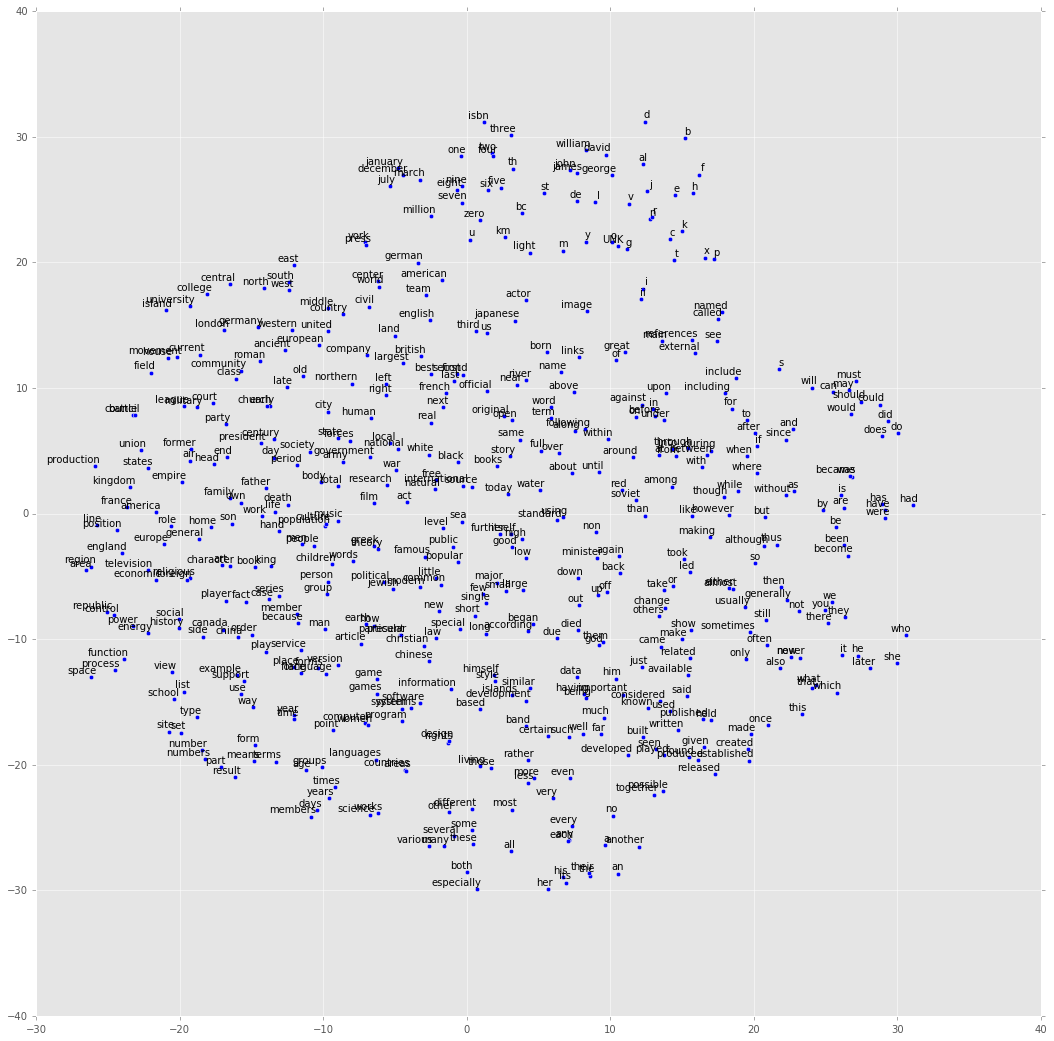

In [13]:
# 可视化 词向量
# Step 6: Visualize the embeddings.

from sklearn.manifold import TSNE # 可视化高维数据工具
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
    plt.show()

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
    # perplexity? 
    # n_components 是词向量维度 Dimension of the embedded space
    # init, Initialization of embedding ?
plot_only = 500 # 只选用500个点
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
labels = [reverse_dictionary[i] for i in xrange(plot_only)]
plot_with_labels(low_dim_embs, labels)

#except ImportError:
#    print("Please install sklearn and matplotlib to visualize embeddings.")
